# Goals

* Display a graph of agent/tool calls in the `SRAgent find-datasets` workflow

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import numpy as np
from pathlib import Path

In [10]:
# get base directory
base_dir = !git rev-parse --show-toplevel
base_dir = Path(base_dir[0])
base_dir

PosixPath('/home/nickyoungblut/dev/python/scBaseCount_analysis')

In [41]:
# Define the tool data
tool_data = {
    'invoke_find_datasets_workflow': 80.171162,
    'invoke_sragent_agent': 47.577161,
    'invoke_tissue_ontology_workflow': 44.598162,
    'invoke_tissue_ontology_agent': 33.664545,
    'invoke_entrez_agent': 26.859475,
    'invoke_ncbi_fetch_agent': 11.956634,
    'invoke_bigquery_agent': 10.531875,
    'invoke_efetch_agent': 8.543383,
    'invoke_esummary_agent': 7.217007,
    'fetch_bioproject_record': 4.685145,
    'invoke_esearch_agent': 3.190766,
    'invoke_find_datasets_agent': 2.960510,
    'invoke_elink_agent': 2.022246,
    'which_entrez_databases': 2.011831,
    'fetch_biosample_record': 1.976901,
    'fetch_ncbi_record': 1.878156,
    'get_study_experiment_run': 1.551075,
    'esearch': 1.521951,
    'get_experiment_metadata': 1.416495,
    'get_neighbors': 1.414890,
    'efetch': 1.337617,
    'get_run_metadata': 1.285950,
    'get_study_metadata': 1.280950,
    'fetch_geo_record': 1.171605,
    'esearch_scrna': 1.084330,
    'query_vector_db': 1.030593,
    'esummary': 0.953450,
    'query_uberon_ols': 0.631449,
    'elink': 0.366440,
}

# Create a directed graph
G = nx.DiGraph()

# Add nodes with duration as attribute
for tool, duration in tool_data.items():
    G.add_node(tool, duration=duration)

# Define the hierarchy based on the codebase analysis
edges = [
    # Main workflow
    ('invoke_find_datasets_workflow', 'invoke_find_datasets_agent'),
    ('invoke_find_datasets_workflow', 'invoke_sragent_agent'),
    ('invoke_sragent_agent', 'invoke_entrez_agent'),
    ('invoke_sragent_agent', 'invoke_ncbi_fetch_agent'),
    ('invoke_sragent_agent', 'invoke_bigquery_agent'),
    ('invoke_sragent_agent', 'invoke_tissue_ontology_workflow'),
    
    # Tissue ontology workflow
    ('invoke_tissue_ontology_workflow', 'invoke_tissue_ontology_agent'),
    ('invoke_tissue_ontology_agent', 'query_uberon_ols'),
    
    # Find datasets agent
    ('invoke_find_datasets_agent', 'esearch_scrna'),
    
    # Entrez agent and its tools
    ('invoke_entrez_agent', 'invoke_esearch_agent'),
    ('invoke_entrez_agent', 'invoke_efetch_agent'),
    ('invoke_entrez_agent', 'invoke_esummary_agent'),
    ('invoke_entrez_agent', 'invoke_elink_agent'),
    ('invoke_entrez_agent', 'which_entrez_databases'),
    
    # Direct tool calls from Entrez sub-agents
    ('invoke_esearch_agent', 'esearch'),
    ('invoke_efetch_agent', 'efetch'),
    ('invoke_esummary_agent', 'esummary'),
    ('invoke_elink_agent', 'elink'),
    ('invoke_elink_agent', 'get_neighbors'),
    
    # NCBI Fetch agent and its tools
    ('invoke_ncbi_fetch_agent', 'fetch_bioproject_record'),
    ('invoke_ncbi_fetch_agent', 'fetch_biosample_record'),
    ('invoke_ncbi_fetch_agent', 'fetch_ncbi_record'),
    ('invoke_ncbi_fetch_agent', 'fetch_geo_record'),
    
    # BigQuery agent and its tools
    ('invoke_bigquery_agent', 'get_study_experiment_run'),
    ('invoke_bigquery_agent', 'get_experiment_metadata'),
    ('invoke_bigquery_agent', 'get_run_metadata'),
    ('invoke_bigquery_agent', 'get_study_metadata'),
    
    # Vector DB might be used by tissue ontology
    ('invoke_tissue_ontology_agent', 'query_vector_db'),
]

# Add edges to the graph
G.add_edges_from(edges)

In [42]:
# Verify all nodes have duration data
missing_nodes = set(G.nodes()) - set(tool_data.keys())
if missing_nodes:
    print(f"Warning: Missing duration data for nodes: {missing_nodes}")

# Calculate depth of each node for hierarchical positioning
root = 'invoke_find_datasets_workflow'
depths = nx.single_source_shortest_path_length(G, root)

Note: Graphviz not available, using custom hierarchical layout


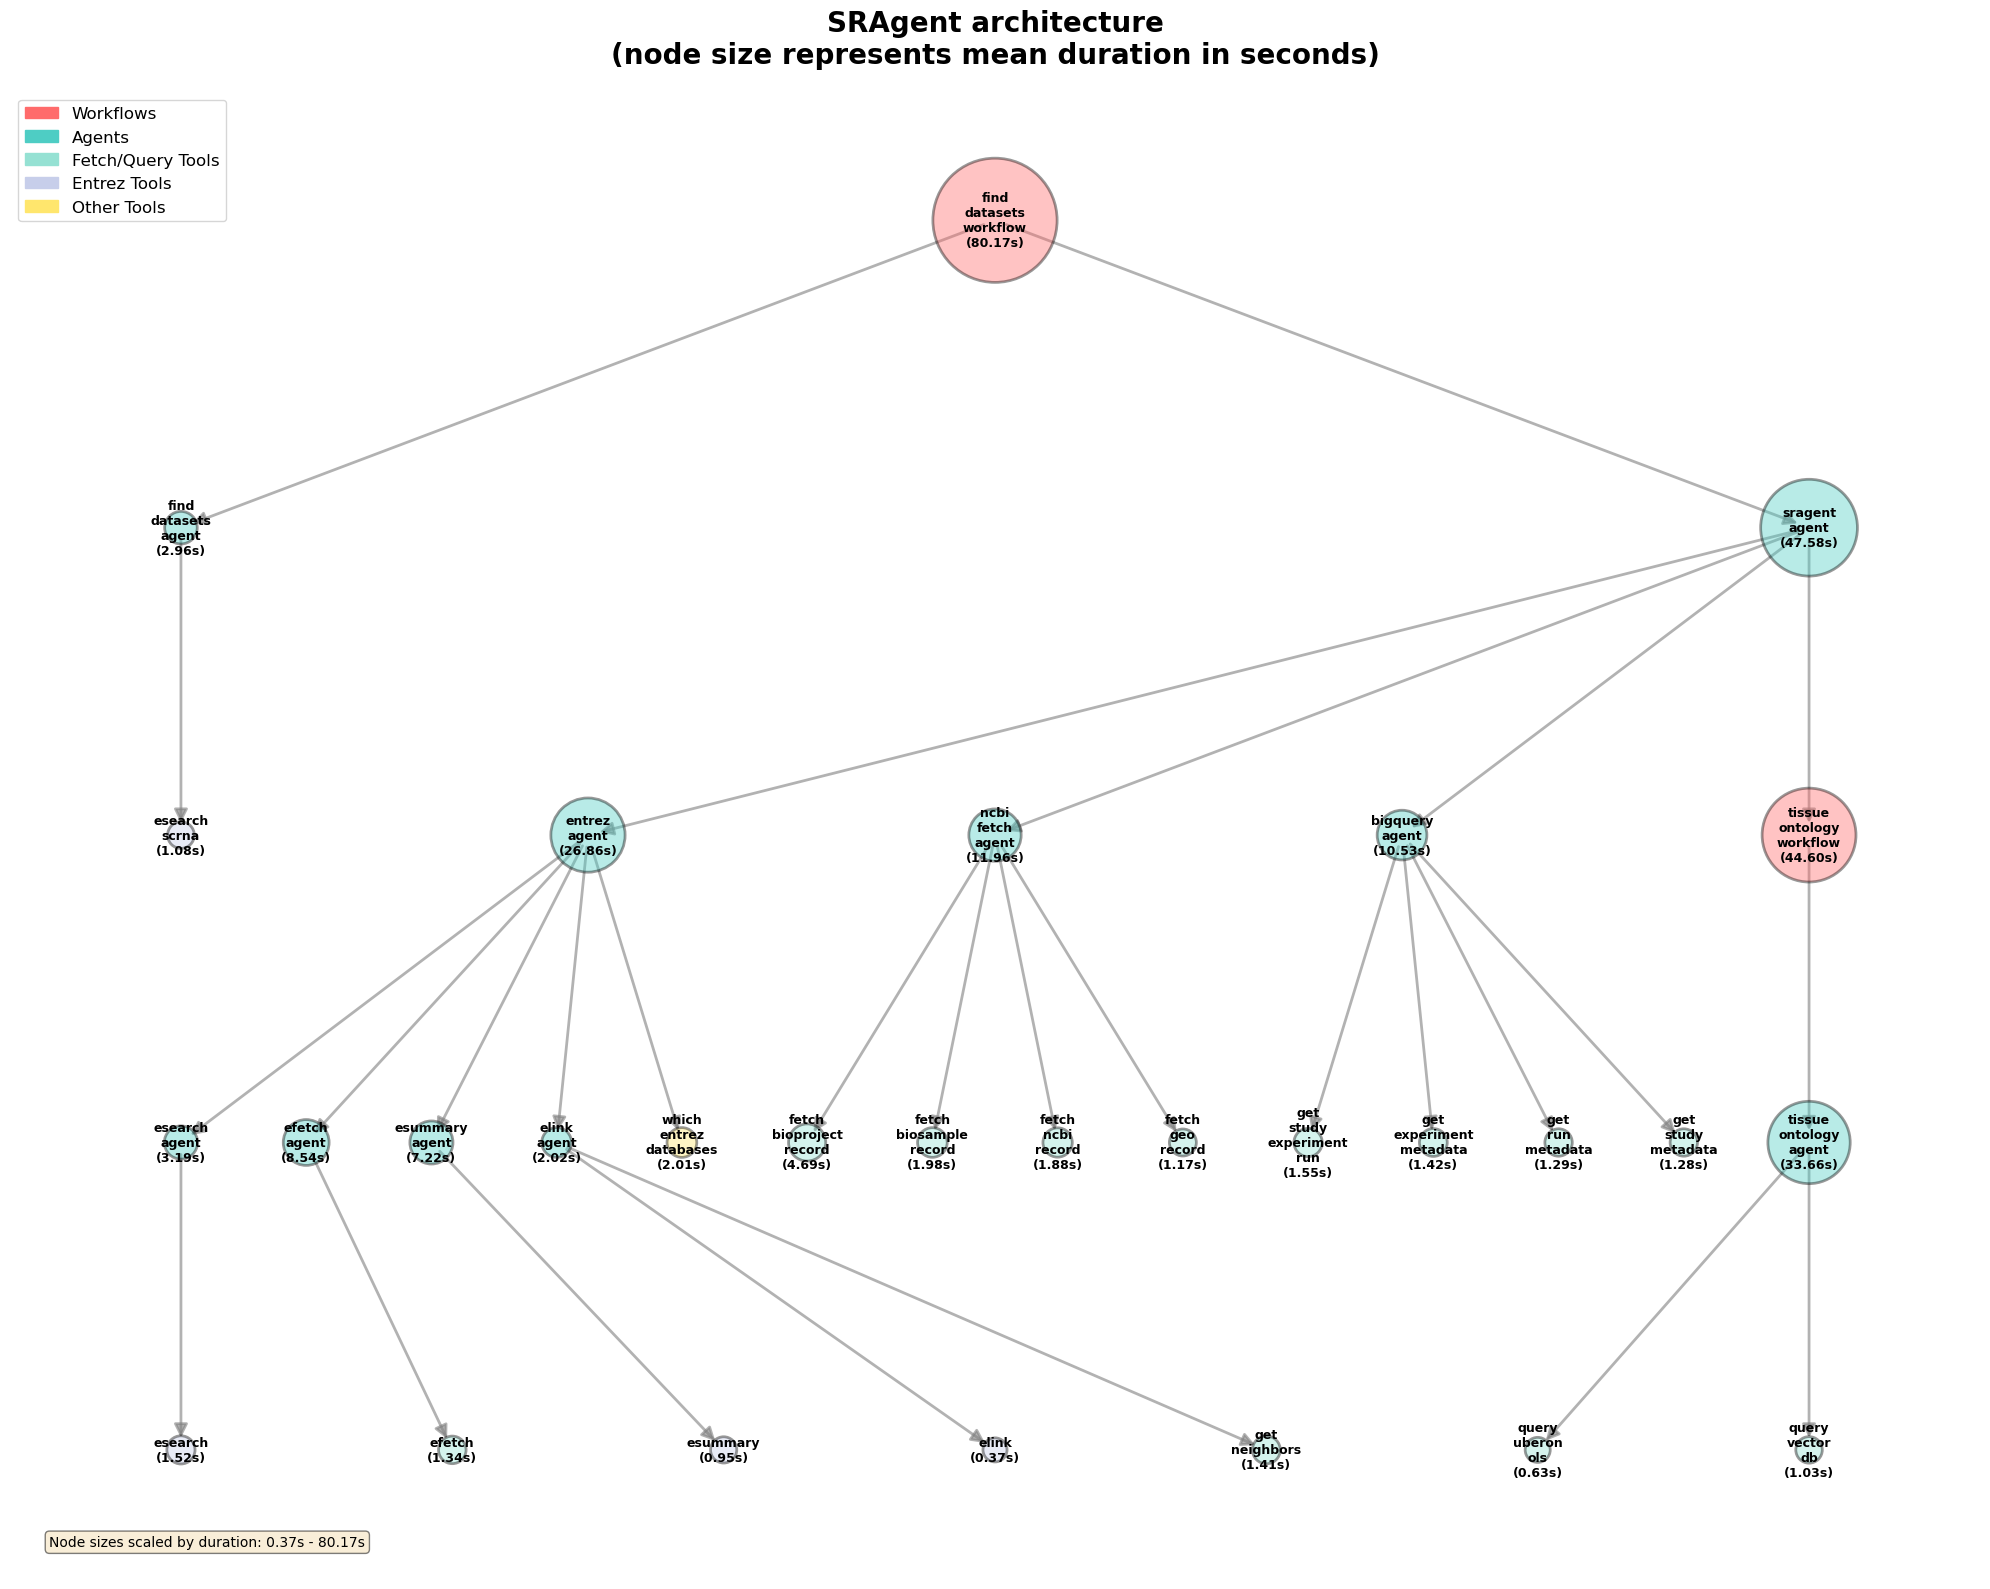

In [45]:
# Alternative: Create custom hierarchical layout
def create_hierarchical_layout(G, root, width=6, height=1.5):
    """Create a hierarchical layout without graphviz"""
    pos = {}
    levels = {}
    
    # Group nodes by depth
    for node, depth in depths.items():
        if depth not in levels:
            levels[depth] = []
        levels[depth].append(node)
    
    # Position nodes
    for depth, nodes in levels.items():
        n_nodes = len(nodes)
        for i, node in enumerate(nodes):
            # Spread nodes horizontally at each level
            x = (i - (n_nodes - 1) / 2) * width / max(1, n_nodes - 1)
            y = -depth * height
            pos[node] = (x, y)
    
    return pos

# Create the plot
plt.figure(figsize=(20, 16))

# Use hierarchical layout with fallback
try:
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
except:
    # Fallback to custom hierarchical layout if graphviz is not available
    print("Note: Graphviz not available, using custom hierarchical layout")
    pos = create_hierarchical_layout(G, root)

# Normalize node sizes based on duration (scale between 300 and 8000)
durations = [tool_data[node] for node in G.nodes()]
min_duration = min(durations)
max_duration = max(durations)
node_sizes = [300 + (duration - min_duration) / (max_duration - min_duration) * 7700 
              for duration in durations]

# Define colors for different agent types
node_colors = []
for node in G.nodes():
    if 'workflow' in node:
        node_colors.append('#FF6B6B')  # Red for workflows
    elif 'agent' in node:
        node_colors.append('#4ECDC4')  # Teal for agents
    elif any(x in node for x in ['fetch', 'get', 'query']):
        node_colors.append('#95E1D3')  # Light green for fetch/get/query tools
    elif any(x in node for x in ['esearch', 'efetch', 'esummary', 'elink']):
        node_colors.append('#C7CEEA')  # Light purple for Entrez tools
    else:
        node_colors.append('#FFE66D')  # Yellow for other tools

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, 
                       alpha=0.4, linewidths=2, edgecolors='black')
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, 
                       arrowsize=20, arrowstyle='-|>', width=2, alpha=0.6)

# Add labels with duration
labels = {}
for node in G.nodes():
    duration = tool_data[node]
    # Shorten long names for readability
    short_name = node.replace('invoke_', '').replace('_', ' ')
    short_name = short_name.replace(' ', '\n')
    labels[node] = f"{short_name}\n({duration:.2f}s)"

nx.draw_networkx_labels(G, pos, labels, font_size=9, font_weight='bold')

# Add title and legend
plt.title("SRAgent architecture\n(node size represents mean duration in seconds)", 
          fontsize=20, fontweight='bold', pad=20)

# Create custom legend
legend_elements = [
    mpatches.Patch(color='#FF6B6B', label='Workflows'),
    mpatches.Patch(color='#4ECDC4', label='Agents'),
    mpatches.Patch(color='#95E1D3', label='Fetch/Query Tools'),
    mpatches.Patch(color='#C7CEEA', label='Entrez Tools'),
    mpatches.Patch(color='#FFE66D', label='Other Tools')
]
plt.legend(handles=legend_elements, loc='upper left', fontsize=12)

# Add note about node sizes
plt.text(0.02, 0.02, f"Node sizes scaled by duration: {min_duration:.2f}s - {max_duration:.2f}s", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.axis('off')
plt.tight_layout()
plt.show()

In [44]:
png_path = base_dir / 'figures' / 'sragent_hierarchy_graph_time.png'
plt.savefig(png_path, dpi=150, bbox_inches='tight', facecolor='white')

svg_path = base_dir / 'figures' / 'sragent_hierarchy_graph_time.svg'
plt.savefig(svg_path, format='svg', bbox_inches='tight', facecolor='white')


print(f"✓ Saved hierarchy graph to '{png_path}' and '{svg_path}'")

✓ Saved hierarchy graph to '/home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sragent_hierarchy_graph_time.png' and '/home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sragent_hierarchy_graph_time.svg'


<Figure size 640x480 with 0 Axes>

🚀 Starting SRAgent workflow visualization...
   Save figures: True
   Show figures: True
   Output directory: /home/nickyoungblut/dev/python/scBaseCount_analysis/notebooks/SRAgent

Note: Graphviz not available, using custom hierarchical layout
✓ Saved hierarchy graph to './sragent_hierarchy_graph.png' and './sragent_hierarchy_graph.svg'


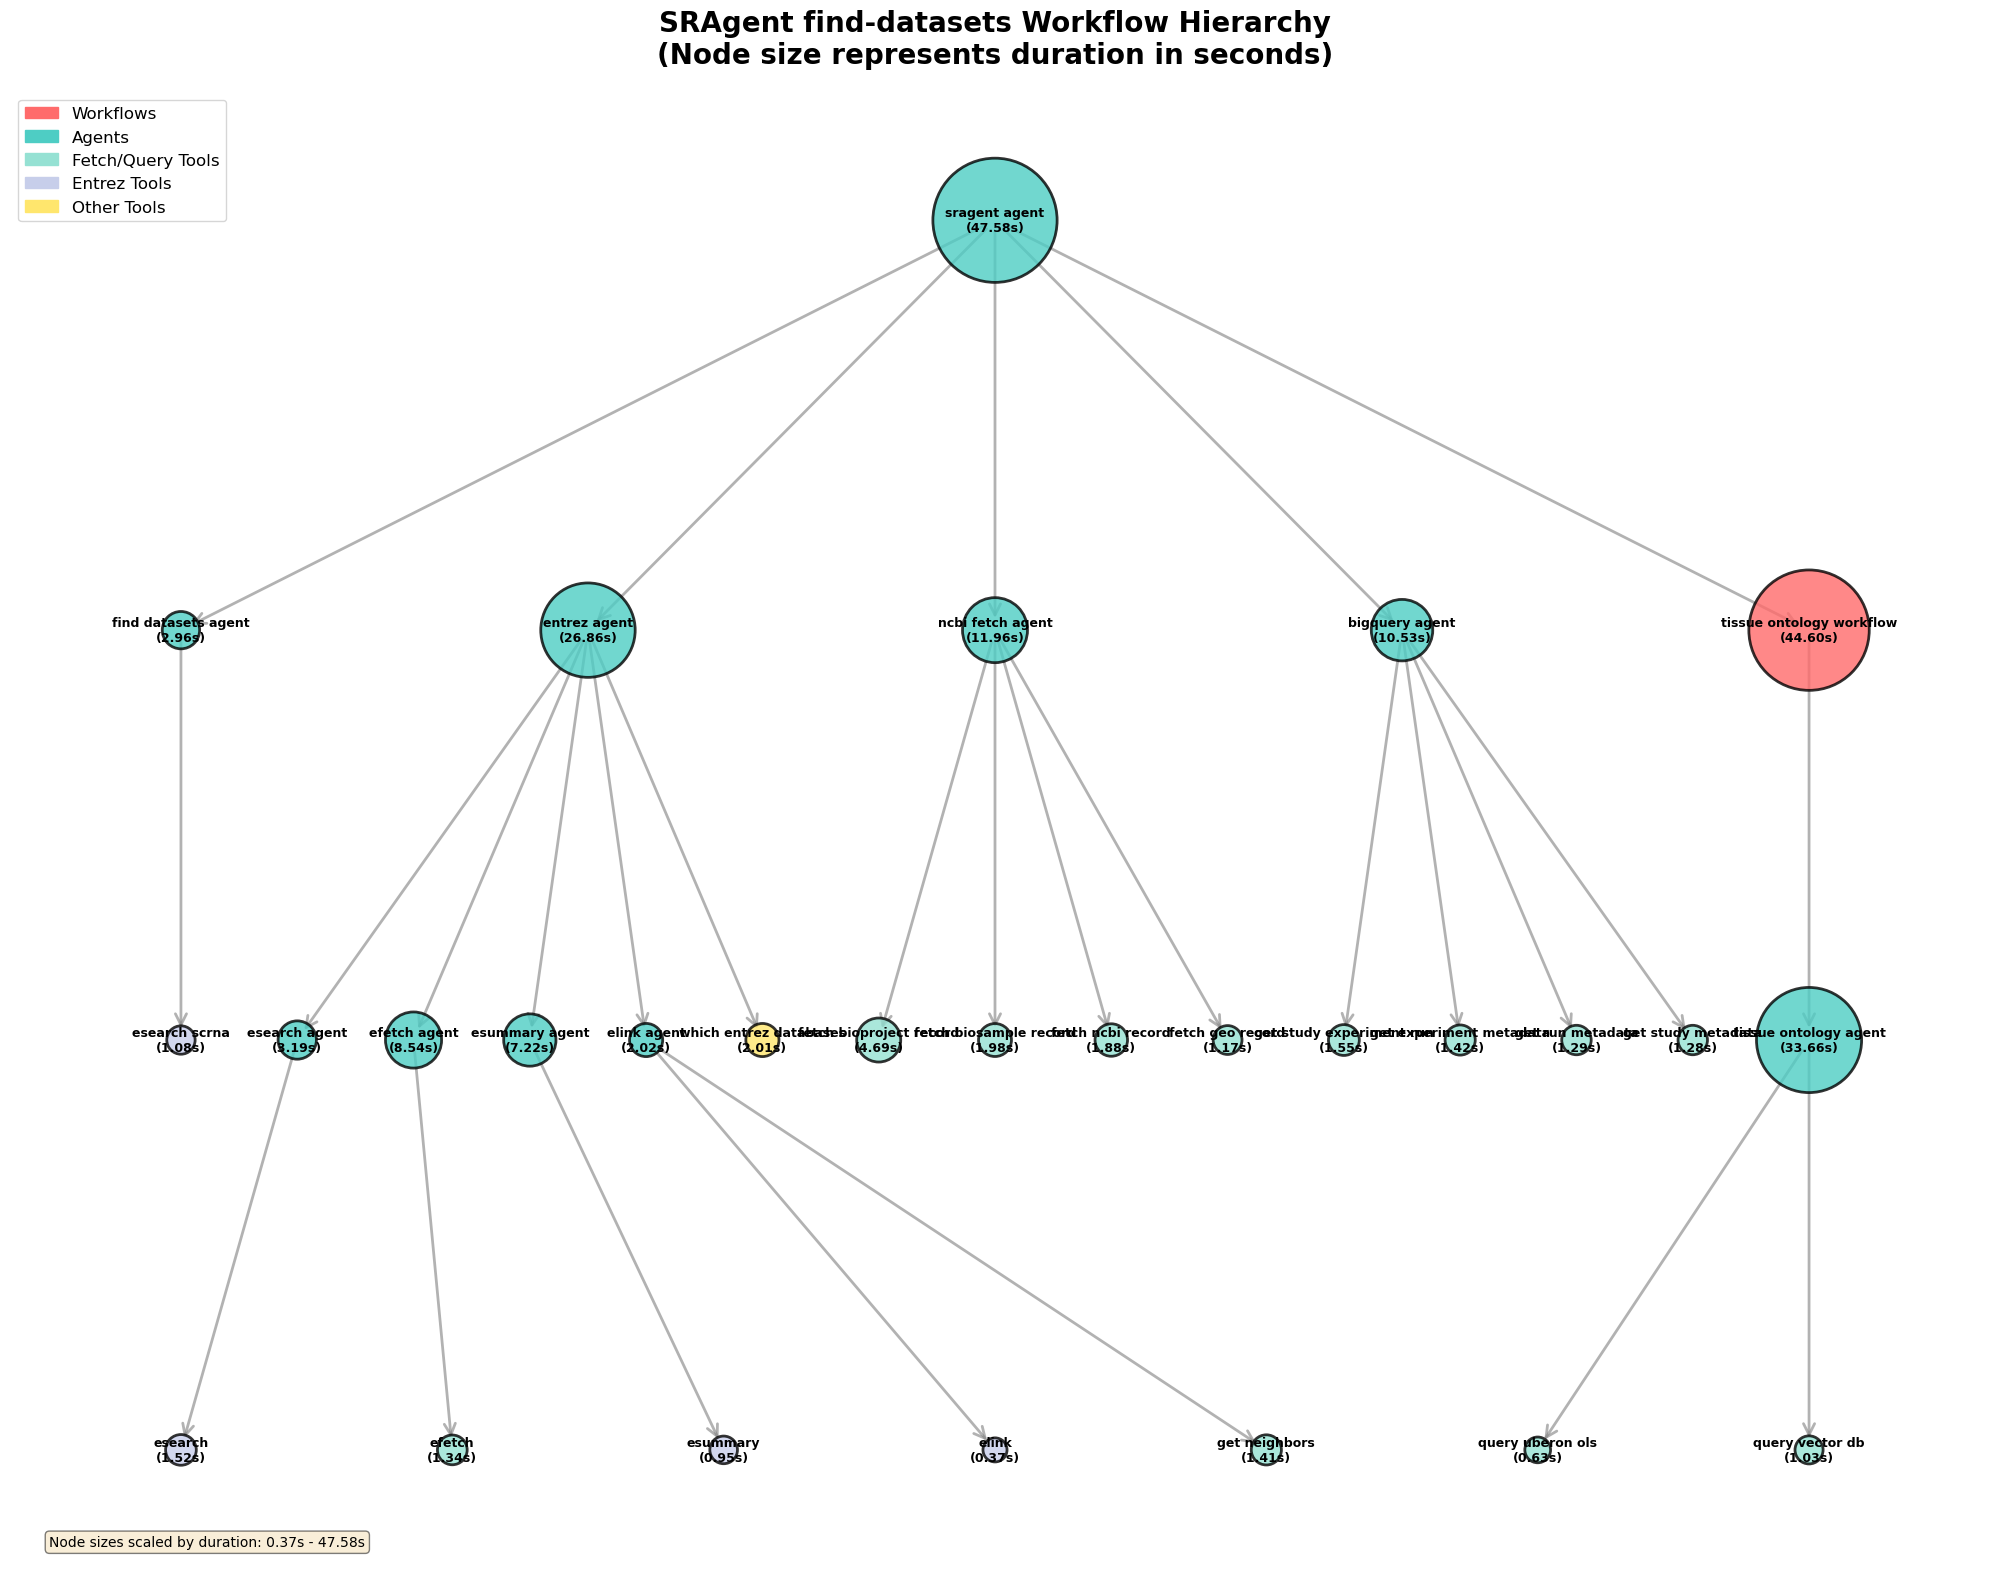

✓ Saved analysis charts to './sragent_workflow_analysis.png' and './sragent_workflow_analysis.svg'


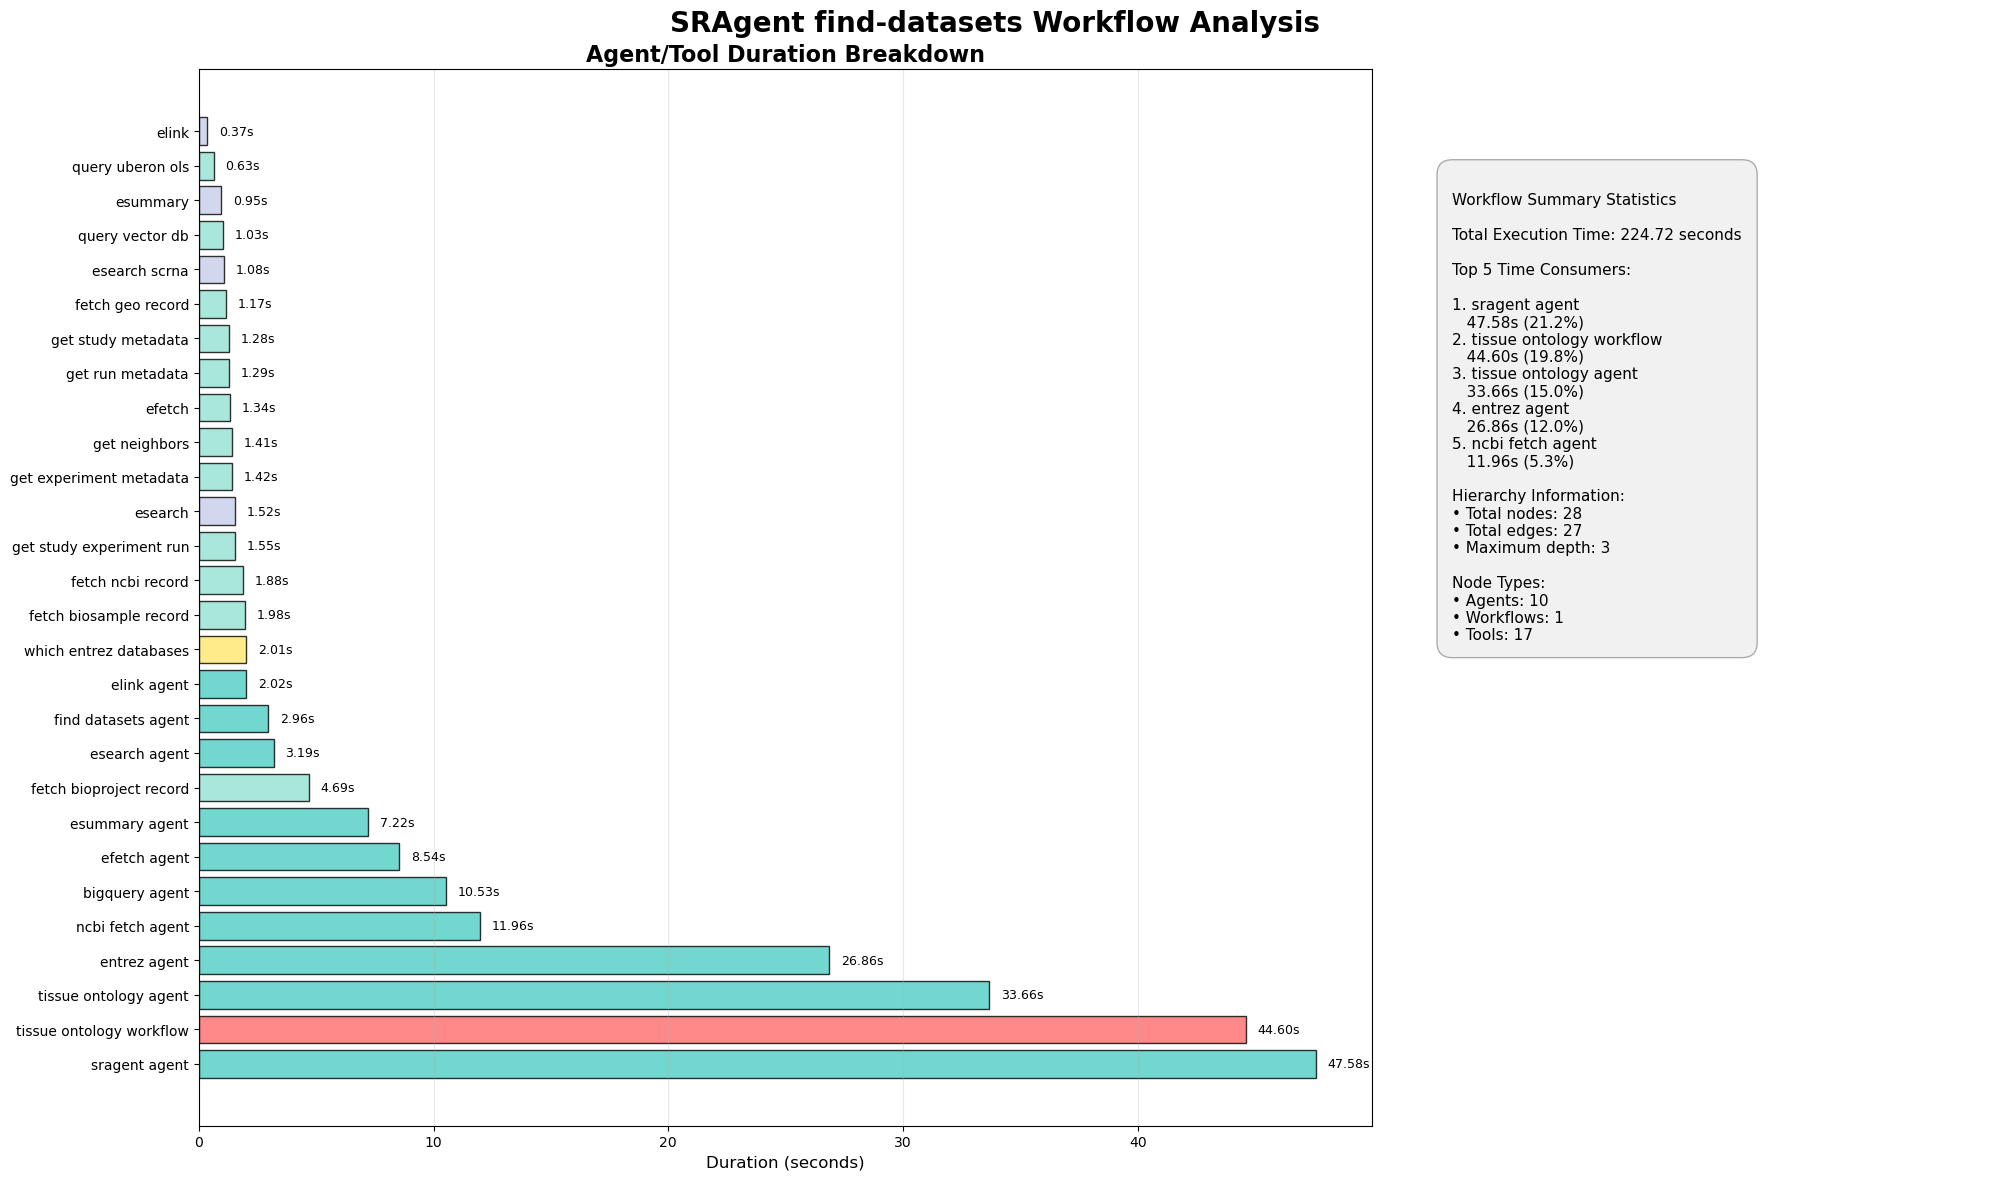


📊 Files saved successfully:
  Output directory: /home/nickyoungblut/dev/python/scBaseCount_analysis/notebooks/SRAgent
  Files created:
    1. sragent_hierarchy_graph.png/svg - Hierarchical workflow visualization
    2. sragent_workflow_analysis.png/svg - Duration analysis and statistics

  PNG Resolution: 300 DPI (print quality)
  SVG Format: Vector graphics (infinitely scalable)

💡 Tip: SVG files are best for publications and presentations

✅ Script completed successfully!
Workflow Statistics:
--------------------------------------------------
Total duration: 224.72 seconds
Number of nodes: 28
Number of edges: 27

Top 5 longest-running tools:
  invoke_sragent_agent: 47.58s
  invoke_tissue_ontology_workflow: 44.60s
  invoke_tissue_ontology_agent: 33.66s
  invoke_entrez_agent: 26.86s
  invoke_ncbi_fetch_agent: 11.96s

Hierarchy depths:
  Level 0: invoke_sragent_agent
  Level 1: invoke_find_datasets_agent, invoke_entrez_agent, invoke_ncbi_fetch_agent, invoke_bigquery_agent, invoke_tissu

In [4]:
#!/usr/bin/env python3
"""
SRAgent find-datasets Workflow Hierarchy Visualization

This script creates hierarchical graphs showing the relationships between
agents and tools in the SRAgent find-datasets workflow, with node sizes
proportional to their execution duration.

Output:
  - sragent_hierarchy_graph.png/svg - The main hierarchical workflow visualization
  - sragent_workflow_analysis.png/svg - Duration analysis bar chart and statistics

Usage:
  python sragent_hierarchy_graph.py
  
Configuration:
  - Modify SAVE_FIGURES to control file saving
  - Modify SHOW_FIGURES to control interactive display
  - Modify OUTPUT_DIR to change where files are saved
  - Modify DPI to change PNG resolution
"""

# Configuration options
SAVE_FIGURES = True  # Set to True to save figures as PNG and SVG
SHOW_FIGURES = True  # Set to True to display figures interactively
DPI = 300           # Resolution for PNG output (300 is publication quality)
OUTPUT_DIR = "."    # Output directory for saved files (current directory by default)

# Create output directory if needed
import os
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Import required libraries
try:
    import networkx as nx
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from matplotlib.patches import FancyBboxPatch
    import numpy as np
except ImportError as e:
    print(f"Error: Missing required package - {e}")
    print("Please install required packages with: pip install networkx matplotlib numpy")
    raise

print("🚀 Starting SRAgent workflow visualization...")
print(f"   Save figures: {SAVE_FIGURES}")
print(f"   Show figures: {SHOW_FIGURES}")
print(f"   Output directory: {os.path.abspath(OUTPUT_DIR)}\n")

# Define the tool data
tool_data = {
    'invoke_sragent_agent': 47.577161,
    'invoke_tissue_ontology_workflow': 44.598162,
    'invoke_tissue_ontology_agent': 33.664545,
    'invoke_entrez_agent': 26.859475,
    'invoke_ncbi_fetch_agent': 11.956634,
    'invoke_bigquery_agent': 10.531875,
    'invoke_efetch_agent': 8.543383,
    'invoke_esummary_agent': 7.217007,
    'fetch_bioproject_record': 4.685145,
    'invoke_esearch_agent': 3.190766,
    'invoke_find_datasets_agent': 2.960510,
    'invoke_elink_agent': 2.022246,
    'which_entrez_databases': 2.011831,
    'fetch_biosample_record': 1.976901,
    'fetch_ncbi_record': 1.878156,
    'get_study_experiment_run': 1.551075,
    'esearch': 1.521951,
    'get_experiment_metadata': 1.416495,
    'get_neighbors': 1.414890,
    'efetch': 1.337617,
    'get_run_metadata': 1.285950,
    'get_study_metadata': 1.280950,
    'fetch_geo_record': 1.171605,
    'esearch_scrna': 1.084330,
    'query_vector_db': 1.030593,
    'esummary': 0.953450,
    'query_uberon_ols': 0.631449,
    'elink': 0.366440,
}

# Create a directed graph
G = nx.DiGraph()

# Add nodes with duration as attribute
for tool, duration in tool_data.items():
    G.add_node(tool, duration=duration)

# Define the hierarchy based on the codebase analysis
edges = [
    # Main workflow
    ('invoke_sragent_agent', 'invoke_find_datasets_agent'),
    ('invoke_sragent_agent', 'invoke_entrez_agent'),
    ('invoke_sragent_agent', 'invoke_ncbi_fetch_agent'),
    ('invoke_sragent_agent', 'invoke_bigquery_agent'),
    ('invoke_sragent_agent', 'invoke_tissue_ontology_workflow'),
    
    # Tissue ontology workflow
    ('invoke_tissue_ontology_workflow', 'invoke_tissue_ontology_agent'),
    ('invoke_tissue_ontology_agent', 'query_uberon_ols'),
    
    # Find datasets agent
    ('invoke_find_datasets_agent', 'esearch_scrna'),
    
    # Entrez agent and its tools
    ('invoke_entrez_agent', 'invoke_esearch_agent'),
    ('invoke_entrez_agent', 'invoke_efetch_agent'),
    ('invoke_entrez_agent', 'invoke_esummary_agent'),
    ('invoke_entrez_agent', 'invoke_elink_agent'),
    ('invoke_entrez_agent', 'which_entrez_databases'),
    
    # Direct tool calls from Entrez sub-agents
    ('invoke_esearch_agent', 'esearch'),
    ('invoke_efetch_agent', 'efetch'),
    ('invoke_esummary_agent', 'esummary'),
    ('invoke_elink_agent', 'elink'),
    ('invoke_elink_agent', 'get_neighbors'),
    
    # NCBI Fetch agent and its tools
    ('invoke_ncbi_fetch_agent', 'fetch_bioproject_record'),
    ('invoke_ncbi_fetch_agent', 'fetch_biosample_record'),
    ('invoke_ncbi_fetch_agent', 'fetch_ncbi_record'),
    ('invoke_ncbi_fetch_agent', 'fetch_geo_record'),
    
    # BigQuery agent and its tools
    ('invoke_bigquery_agent', 'get_study_experiment_run'),
    ('invoke_bigquery_agent', 'get_experiment_metadata'),
    ('invoke_bigquery_agent', 'get_run_metadata'),
    ('invoke_bigquery_agent', 'get_study_metadata'),
    
    # Vector DB might be used by tissue ontology
    ('invoke_tissue_ontology_agent', 'query_vector_db'),
]

# Add edges to the graph
G.add_edges_from(edges)

# Verify all nodes have duration data
missing_nodes = set(G.nodes()) - set(tool_data.keys())
if missing_nodes:
    print(f"Warning: Missing duration data for nodes: {missing_nodes}")

# Calculate depth of each node for hierarchical positioning
root = 'invoke_sragent_agent'
depths = nx.single_source_shortest_path_length(G, root)

# Alternative: Create custom hierarchical layout
def create_hierarchical_layout(G, root, width=6, height=1.5):
    """Create a hierarchical layout without graphviz"""
    pos = {}
    levels = {}
    
    # Group nodes by depth
    for node, depth in depths.items():
        if depth not in levels:
            levels[depth] = []
        levels[depth].append(node)
    
    # Position nodes
    for depth, nodes in levels.items():
        n_nodes = len(nodes)
        for i, node in enumerate(nodes):
            # Spread nodes horizontally at each level
            x = (i - (n_nodes - 1) / 2) * width / max(1, n_nodes - 1)
            y = -depth * height
            pos[node] = (x, y)
    
    return pos

# Create the plot
plt.figure(figsize=(20, 16))

# Use hierarchical layout with fallback
try:
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
except:
    # Fallback to custom hierarchical layout if graphviz is not available
    print("Note: Graphviz not available, using custom hierarchical layout")
    pos = create_hierarchical_layout(G, root)

# Normalize node sizes based on duration (scale between 300 and 8000)
durations = [tool_data[node] for node in G.nodes()]
min_duration = min(durations)
max_duration = max(durations)
node_sizes = [300 + (duration - min_duration) / (max_duration - min_duration) * 7700 
              for duration in durations]

# Define colors for different agent types
node_colors = []
for node in G.nodes():
    if 'workflow' in node:
        node_colors.append('#FF6B6B')  # Red for workflows
    elif 'agent' in node:
        node_colors.append('#4ECDC4')  # Teal for agents
    elif any(x in node for x in ['fetch', 'get', 'query']):
        node_colors.append('#95E1D3')  # Light green for fetch/get/query tools
    elif any(x in node for x in ['esearch', 'efetch', 'esummary', 'elink']):
        node_colors.append('#C7CEEA')  # Light purple for Entrez tools
    else:
        node_colors.append('#FFE66D')  # Yellow for other tools

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, 
                       alpha=0.8, linewidths=2, edgecolors='black')
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, 
                       arrowsize=20, arrowstyle='->', width=2, alpha=0.6)

# Add labels with duration
labels = {}
for node in G.nodes():
    duration = tool_data[node]
    # Shorten long names for readability
    short_name = node.replace('invoke_', '').replace('_', ' ')
    labels[node] = f"{short_name}\n({duration:.2f}s)"

nx.draw_networkx_labels(G, pos, labels, font_size=9, font_weight='bold')

# Add title and legend
plt.title("SRAgent find-datasets Workflow Hierarchy\n(Node size represents duration in seconds)", 
          fontsize=20, fontweight='bold', pad=20)

# Create custom legend
legend_elements = [
    mpatches.Patch(color='#FF6B6B', label='Workflows'),
    mpatches.Patch(color='#4ECDC4', label='Agents'),
    mpatches.Patch(color='#95E1D3', label='Fetch/Query Tools'),
    mpatches.Patch(color='#C7CEEA', label='Entrez Tools'),
    mpatches.Patch(color='#FFE66D', label='Other Tools')
]
plt.legend(handles=legend_elements, loc='upper left', fontsize=12)

# Add note about node sizes
plt.text(0.02, 0.02, f"Node sizes scaled by duration: {min_duration:.2f}s - {max_duration:.2f}s", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.axis('off')
plt.tight_layout()

# Save the hierarchy graph
if SAVE_FIGURES:
    try:
        png_path = os.path.join(OUTPUT_DIR, 'sragent_hierarchy_graph.png')
        svg_path = os.path.join(OUTPUT_DIR, 'sragent_hierarchy_graph.svg')
        plt.savefig(png_path, dpi=DPI, bbox_inches='tight', facecolor='white')
        plt.savefig(svg_path, format='svg', bbox_inches='tight', facecolor='white')
        print(f"✓ Saved hierarchy graph to '{png_path}' and '{svg_path}'")
    except Exception as e:
        print(f"❌ Error saving hierarchy graph: {e}")

if SHOW_FIGURES:
    try:
        plt.show()
    except:
        print("⚠️  Unable to display figures interactively (may be running in non-GUI environment)")
else:
    plt.close()

# Create a second figure showing duration breakdown
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12), gridspec_kw={'width_ratios': [2, 1]})

# Left plot: Horizontal bar chart of durations
sorted_tools = sorted(tool_data.items(), key=lambda x: x[1], reverse=True)
tools = [t[0].replace('invoke_', '').replace('_', ' ') for t in sorted_tools]
durations_sorted = [t[1] for t in sorted_tools]

# Define colors for bars based on tool type
bar_colors = []
for tool, _ in sorted_tools:
    if 'workflow' in tool:
        bar_colors.append('#FF6B6B')
    elif 'agent' in tool:
        bar_colors.append('#4ECDC4')
    elif any(x in tool for x in ['fetch', 'get', 'query']):
        bar_colors.append('#95E1D3')
    elif any(x in tool for x in ['esearch', 'efetch', 'esummary', 'elink']):
        bar_colors.append('#C7CEEA')
    else:
        bar_colors.append('#FFE66D')

y_pos = np.arange(len(tools))
bars = ax1.barh(y_pos, durations_sorted, color=bar_colors, alpha=0.8, edgecolor='black', linewidth=1)

# Add value labels on bars
for i, (bar, duration) in enumerate(zip(bars, durations_sorted)):
    ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{duration:.2f}s', va='center', fontsize=9)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(tools)
ax1.set_xlabel('Duration (seconds)', fontsize=12)
ax1.set_title('Agent/Tool Duration Breakdown', fontsize=16, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Right plot: Summary statistics
ax2.axis('off')
summary_text = f"""
Workflow Summary Statistics

Total Execution Time: {sum(durations):.2f} seconds

Top 5 Time Consumers:
"""
for i, (tool, duration) in enumerate(sorted_tools[:5]):
    pct = (duration / sum(durations)) * 100
    summary_text += f"\n{i+1}. {tool.replace('invoke_', '').replace('_', ' ')}"
    summary_text += f"\n   {duration:.2f}s ({pct:.1f}%)"

summary_text += f"\n\nHierarchy Information:"
summary_text += f"\n• Total nodes: {G.number_of_nodes()}"
summary_text += f"\n• Total edges: {G.number_of_edges()}"
summary_text += f"\n• Maximum depth: {max(depths.values())}"

# Count nodes by type
agent_count = sum(1 for node in G.nodes() if 'agent' in node)
workflow_count = sum(1 for node in G.nodes() if 'workflow' in node)
tool_count = G.number_of_nodes() - agent_count - workflow_count

summary_text += f"\n\nNode Types:"
summary_text += f"\n• Agents: {agent_count}"
summary_text += f"\n• Workflows: {workflow_count}"
summary_text += f"\n• Tools: {tool_count}"

ax2.text(0.1, 0.9, summary_text, transform=ax2.transAxes, 
         fontsize=11, verticalalignment='top', 
         bbox=dict(boxstyle='round,pad=1', facecolor='lightgray', alpha=0.3))

plt.suptitle('SRAgent find-datasets Workflow Analysis', fontsize=20, fontweight='bold')
plt.tight_layout()

# Save the analysis charts
if SAVE_FIGURES:
    try:
        png_path = os.path.join(OUTPUT_DIR, 'sragent_workflow_analysis.png')
        svg_path = os.path.join(OUTPUT_DIR, 'sragent_workflow_analysis.svg')
        plt.savefig(png_path, dpi=DPI, bbox_inches='tight', facecolor='white')
        plt.savefig(svg_path, format='svg', bbox_inches='tight', facecolor='white')
        print(f"✓ Saved analysis charts to '{png_path}' and '{svg_path}'")
    except Exception as e:
        print(f"❌ Error saving analysis charts: {e}")

if SHOW_FIGURES:
    try:
        plt.show()
    except:
        print("⚠️  Unable to display figures interactively (may be running in non-GUI environment)")
else:
    plt.close()

# Print summary of saved files
if SAVE_FIGURES:
    print("\n📊 Files saved successfully:")
    print(f"  Output directory: {os.path.abspath(OUTPUT_DIR)}")
    print("  Files created:")
    print("    1. sragent_hierarchy_graph.png/svg - Hierarchical workflow visualization")
    print("    2. sragent_workflow_analysis.png/svg - Duration analysis and statistics")
    print(f"\n  PNG Resolution: {DPI} DPI (print quality)")
    print("  SVG Format: Vector graphics (infinitely scalable)")
    print("\n💡 Tip: SVG files are best for publications and presentations")

print("\n✅ Script completed successfully!")

# Print some statistics
print("Workflow Statistics:")
print("-" * 50)
print(f"Total duration: {sum(durations):.2f} seconds")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print("\nTop 5 longest-running tools:")
for tool, duration in sorted(tool_data.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"  {tool}: {duration:.2f}s")

print("\nHierarchy depths:")
for depth in range(max(depths.values()) + 1):
    nodes_at_depth = [node for node, d in depths.items() if d == depth]
    print(f"  Level {depth}: {', '.join(nodes_at_depth)}")